# EDA Análisis exploratorio de datos

## Importando librerías

In [1]:
import re
import sketch
import numpy as np 
import pandas as pd 
#import pandas_alive
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary

### Ingesta de datos desde el dataset limpio `siniestros_limpio`

In [4]:
df= pd.read_csv("data/siniestos_limpio.csv")
df.head(3)

,Id,Fecha,Año,Mes,Día,Día semana,Hora completa,Hora,Num víctimas,Participantes,...,Calle,Cruce,Dirección normalizada,Comuna,Barrios,Xy (caba),Coordenada x,Coordenada y,Pos x,Pos y
0,2016-0001,2016-01-01,2016.0,1.0,1.0,Viernes,04:00:00,4.0,1,MOTO-AUTO,...,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.475340,-34.687570
1,2016-0002,2016-01-02,2016.0,1.0,2.0,Sabado,01:15:00,1.0,1,AUTO-PASAJEROS,...,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.508775,-34.669777
2,2016-0003,2016-01-03,2016.0,1.0,3.0,Domingo,07:00:00,7.0,1,MOTO-AUTO,...,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.390403,-34.631894


### Outliers

Se realiza la busqueda de datos con valores atípicos en las features, y se analiza si es necesario eliminarlos.  

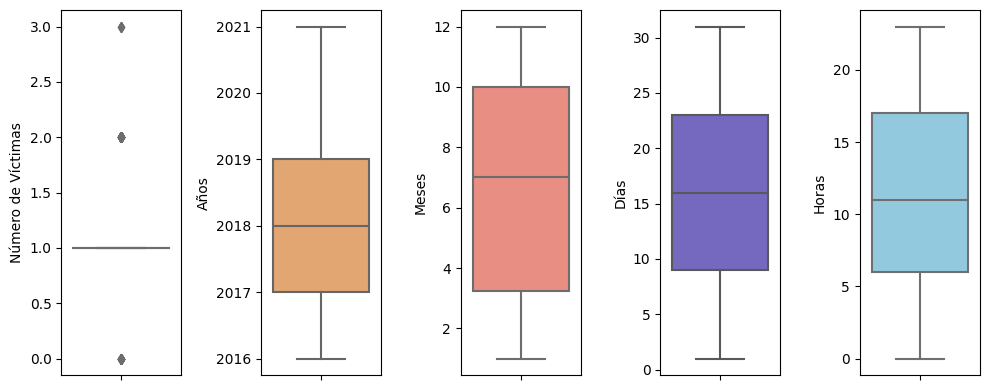

In [18]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 4))

# Crear subplots para los gráficos 
plt.subplot(1, 5, 1) 
sns.boxplot(data=df, y='Num víctimas', color = "#FA8072")
plt.ylabel('Número de Víctimas')

plt.subplot(1, 5, 2) 
sns.boxplot(data=df, y='Año', color = "#F4A460")
plt.ylabel('Años')

plt.subplot(1, 5, 3) 
sns.boxplot(data=df, y='Mes', color = "#FA8072")
plt.ylabel('Meses')

plt.subplot(1, 5, 4) 
sns.boxplot(data=df, y='Día', color = "#6A5ACD")
plt.ylabel('Días')

plt.subplot(1, 5, 5) 
sns.boxplot(data=df, y='Hora', color = "#87CEEB")
plt.ylabel('Horas')

# Ajustar espaciado entre subplots
plt.tight_layout()

plt.show()

#### **Conclusión**
- Los Outliers que se encuentran en feature `Num víctimas` (valores 2 ó 3), se producen debido a que en la mayoria de los casos el registro es el valor uno (1); con respecto a las victimas en los siniestros. 

### Variables Númericas

En el dataset hay variables numéricas ó que contienen números; pero su utilización como tales va a depender del contexto de los datos.
En éste caso se utiliza un mapa de correlaciones para examinar si existen, relaciones entre los datos númericos ó se utilizarán como categóricos (en algunos casos), para el correcto análisis 

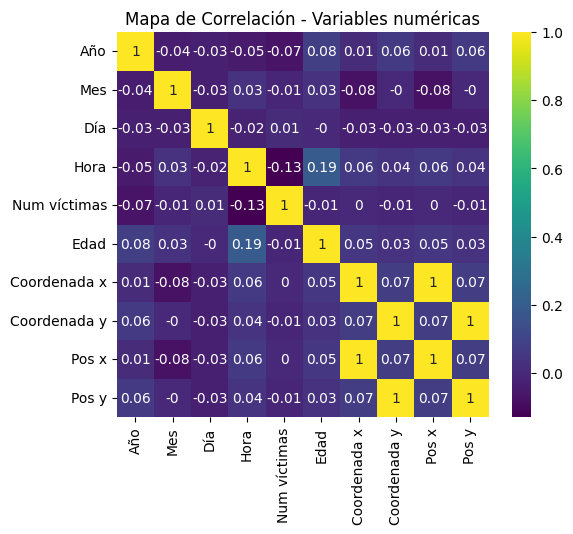

In [20]:
# Generamos un mapa de calor con las correlaciones de los todos los datos que contengan números 
dataNumerica = df.select_dtypes(include=['number']) 
corr = dataNumerica.corr().round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="viridis", annot=True)
plt.title('Mapa de Correlación - Variables numéricas')
plt.show()

El cruzamiento de todas las variables numéricas en la matriz resulta con relaciones positivas fuertes entre las features `Coordenada` y `Pos`, lo que resultaría un dato esperable.
Se puede verificar también una **correlacíon positiva leve** entre la variable `Edad` y `Hora`
Las demás correlaciones son negativas, hecho que se esperaba debido a que el `Num víctimas` de un siniestro no se vincula a una fecha u hora puntual.

Debido al objetivo de éste proyecto, que consiste en analizar los siniestros, con el fin de disminuir la cantidad de víctimas fatales; se define comenzar la exploración con la variable `Num víctimas`.

### `Num víctimas`
- Cantidad de víctimas fatales por siniestro vial

In [23]:
df["Num víctimas"].describe()

count    717.000000
mean       1.037657
std        0.294226
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Num víctimas, dtype: float64

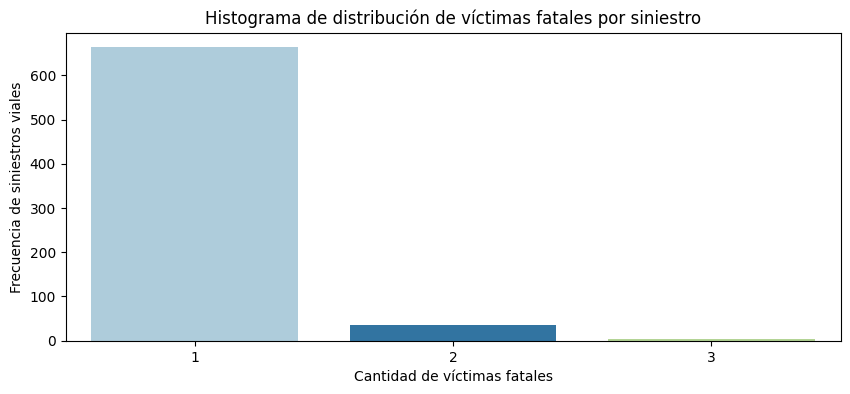

In [22]:
plt.figure(figsize=(10, 4))
# se filtran los valores sin datos o nulos 
df_filtrado = df[df["Num víctimas"] != 0]

#Se cuentan los datos de la columna y se calcula la frecuencia en que se distribuye
sns.countplot(df_filtrado, x='Num víctimas', palette="Paired")

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Histograma de distribución de víctimas fatales por siniestro")

plt.show()

#### **Conclusión**
- La cantidad de víctimas fatales que arrojan los siniestros viales es de 1 (una), en la mayoría de los casos. 
- Según los datos estadísticos de la columna el 75% de los siniestros viales tienen 1 víctima.
- Rara vez resulta un siniestro con tres víctimas fatales 

#### Relación `Num vìctimas` con el tiempo

Se analizan los datos teniendo en cuenta diferentes horizontes temporales, para corroborar la existencia de algún tipo de evento o patrón importante.

In [28]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = df.groupby(['Año', 'Mes'])['Num víctimas'].sum().reset_index()

In [29]:
rel_tiempo

,Año,Mes,Num víctimas
0,2016.0,1.0,8
1,2016.0,2.0,12
2,2016.0,3.0,15
3,2016.0,4.0,9
4,2016.0,5.0,7
...,...,...,...
67,2021.0,8.0,9
68,2021.0,9.0,4
69,2021.0,10.0,5
70,2021.0,11.0,8


In [30]:
#Para la realización del gráfico se transforman los datos a tipo int
rel_tiempo["Año"]= rel_tiempo["Año"].astype("Int64")
rel_tiempo["Mes"]= rel_tiempo["Mes"].astype("Int64")

In [31]:
rel_tiempo

,Año,Mes,Num víctimas
0,2016,1,8
1,2016,2,12
2,2016,3,15
3,2016,4,9
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [32]:
# Combinar AÑO y MES para obtener una sola variable de tiempo, creando la columna "Fecha" como str
rel_tiempo["Fecha"] = rel_tiempo["Año"].astype(str) + '-' + rel_tiempo["Mes"].astype(str)

# Convertir la variable de tiempo a formato datetime
rel_tiempo["Fecha"] = pd.to_datetime(rel_tiempo["Fecha"])

# Ordenar el DataFrame por fecha para que tenga orden cronológico
rel_tiempo = rel_tiempo.sort_values("Fecha")

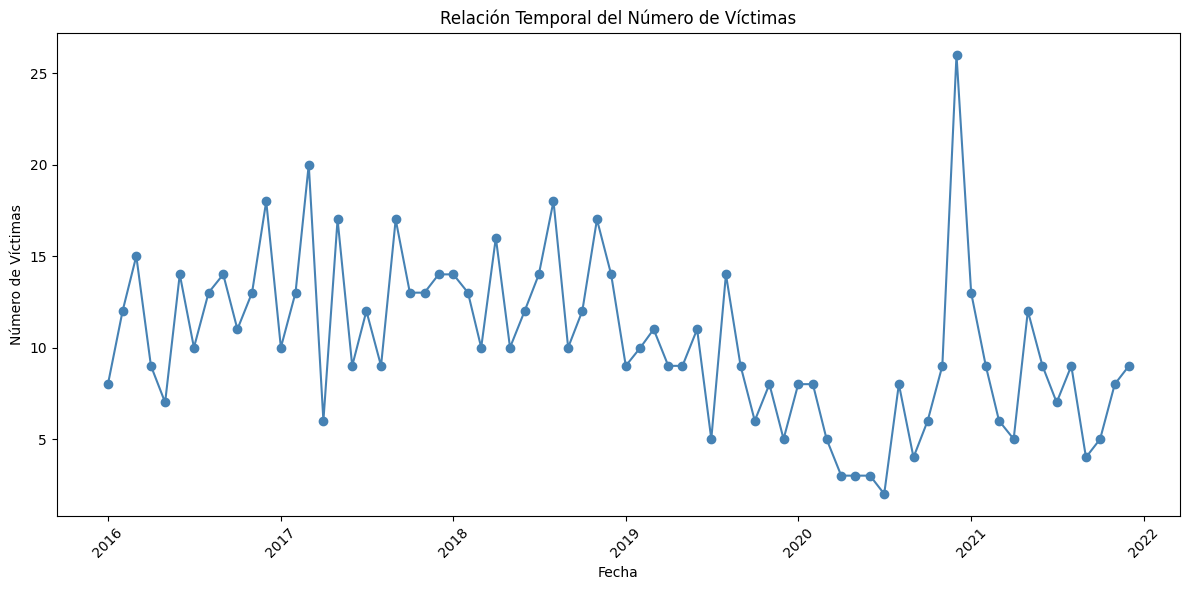

In [33]:
# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(rel_tiempo["Fecha"], rel_tiempo["Num víctimas"], marker='o', color='steelblue')

# Añadir títulos y etiquetas
plt.title('Relación Temporal del Número de Víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()